In [149]:
# import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,cross_val_score
from xgboost import XGBClassifier

In [2]:
# load data
train = pd.read_csv('train_dataset_generated.csv')
test = pd.read_csv('test_dataset_generated.csv')

In [3]:
train.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


# EDA

In [49]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,159256.0,79627.500000,45973.391572,0.0,39813.75,79627.5,119441.25,159255.0
age,159256.0,44.306626,11.842286,20.0,40.00,40.0,55.00,85.0
height(cm),159256.0,165.266929,8.818970,135.0,160.00,165.0,170.00,190.0
weight(kg),159256.0,67.143662,12.586198,30.0,60.00,65.0,75.00,130.0
waist(cm),159256.0,83.001990,8.957937,51.0,77.00,83.0,89.00,127.0
eyesight(left),159256.0,1.005798,0.402113,0.1,0.80,1.0,1.20,9.9
eyesight(right),159256.0,1.000989,0.392299,0.1,0.80,1.0,1.20,9.9
hearing(left),159256.0,1.023974,0.152969,1.0,1.00,1.0,1.00,2.0
hearing(right),159256.0,1.023421,0.151238,1.0,1.00,1.0,1.00,2.0
systolic,159256.0,122.503648,12.729315,77.0,114.00,121.0,130.00,213.0


There are 43.7% people who smoke in the training set, so we do not need to worry about biased prediction when building model.

In [65]:
# check number of outliers for each column
Q1 = train.drop(columns='id').quantile(.25)
Q3 = train.drop(columns='id').quantile(.75)
IQR = Q3 - Q1
outliers = ((train.drop(columns='id') < (Q1 - 2 * IQR)) | (train.drop(columns='id') > (Q3 + 2 * IQR)))
outliers.sum(axis = 0)

age                        0
height(cm)                 9
weight(kg)               342
waist(cm)                103
eyesight(left)           689
eyesight(right)          653
hearing(left)           3818
hearing(right)          3730
systolic                 355
relaxation               288
fasting blood sugar     4795
Cholesterol               65
triglyceride            1190
HDL                      311
LDL                      108
hemoglobin               602
Urine protein           8394
serum creatinine         592
AST                     3382
ALT                     3872
Gtp                     6289
dental caries          31532
smoking                    0
dtype: int64

In [53]:
train[list(outliers.any()[outliers.any() == True].index)].select_dtypes(include='number')

Index(['height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries'],
      dtype='object')

<ipython-input-63-1e28163ac784>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,j].set_xticklabels(xticklables)
<ipython-input-63-1e28163ac784>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,j].set_xticklabels(xticklables)
<ipython-input-63-1e28163ac784>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,j].set_xticklabels(xticklables)
<ipython-input-63-1e28163ac784>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,j].set_xticklabels(xticklables)
<ipython-input-63-1e28163ac784>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,j].set_xticklabels(xticklables)
<ipython-input-63-1e28163ac784>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,j].set_xticklabels(xticklables)
<ipython-input-63-1e28163ac784>:10: UserWarning: FixedFormatter should only be used together w

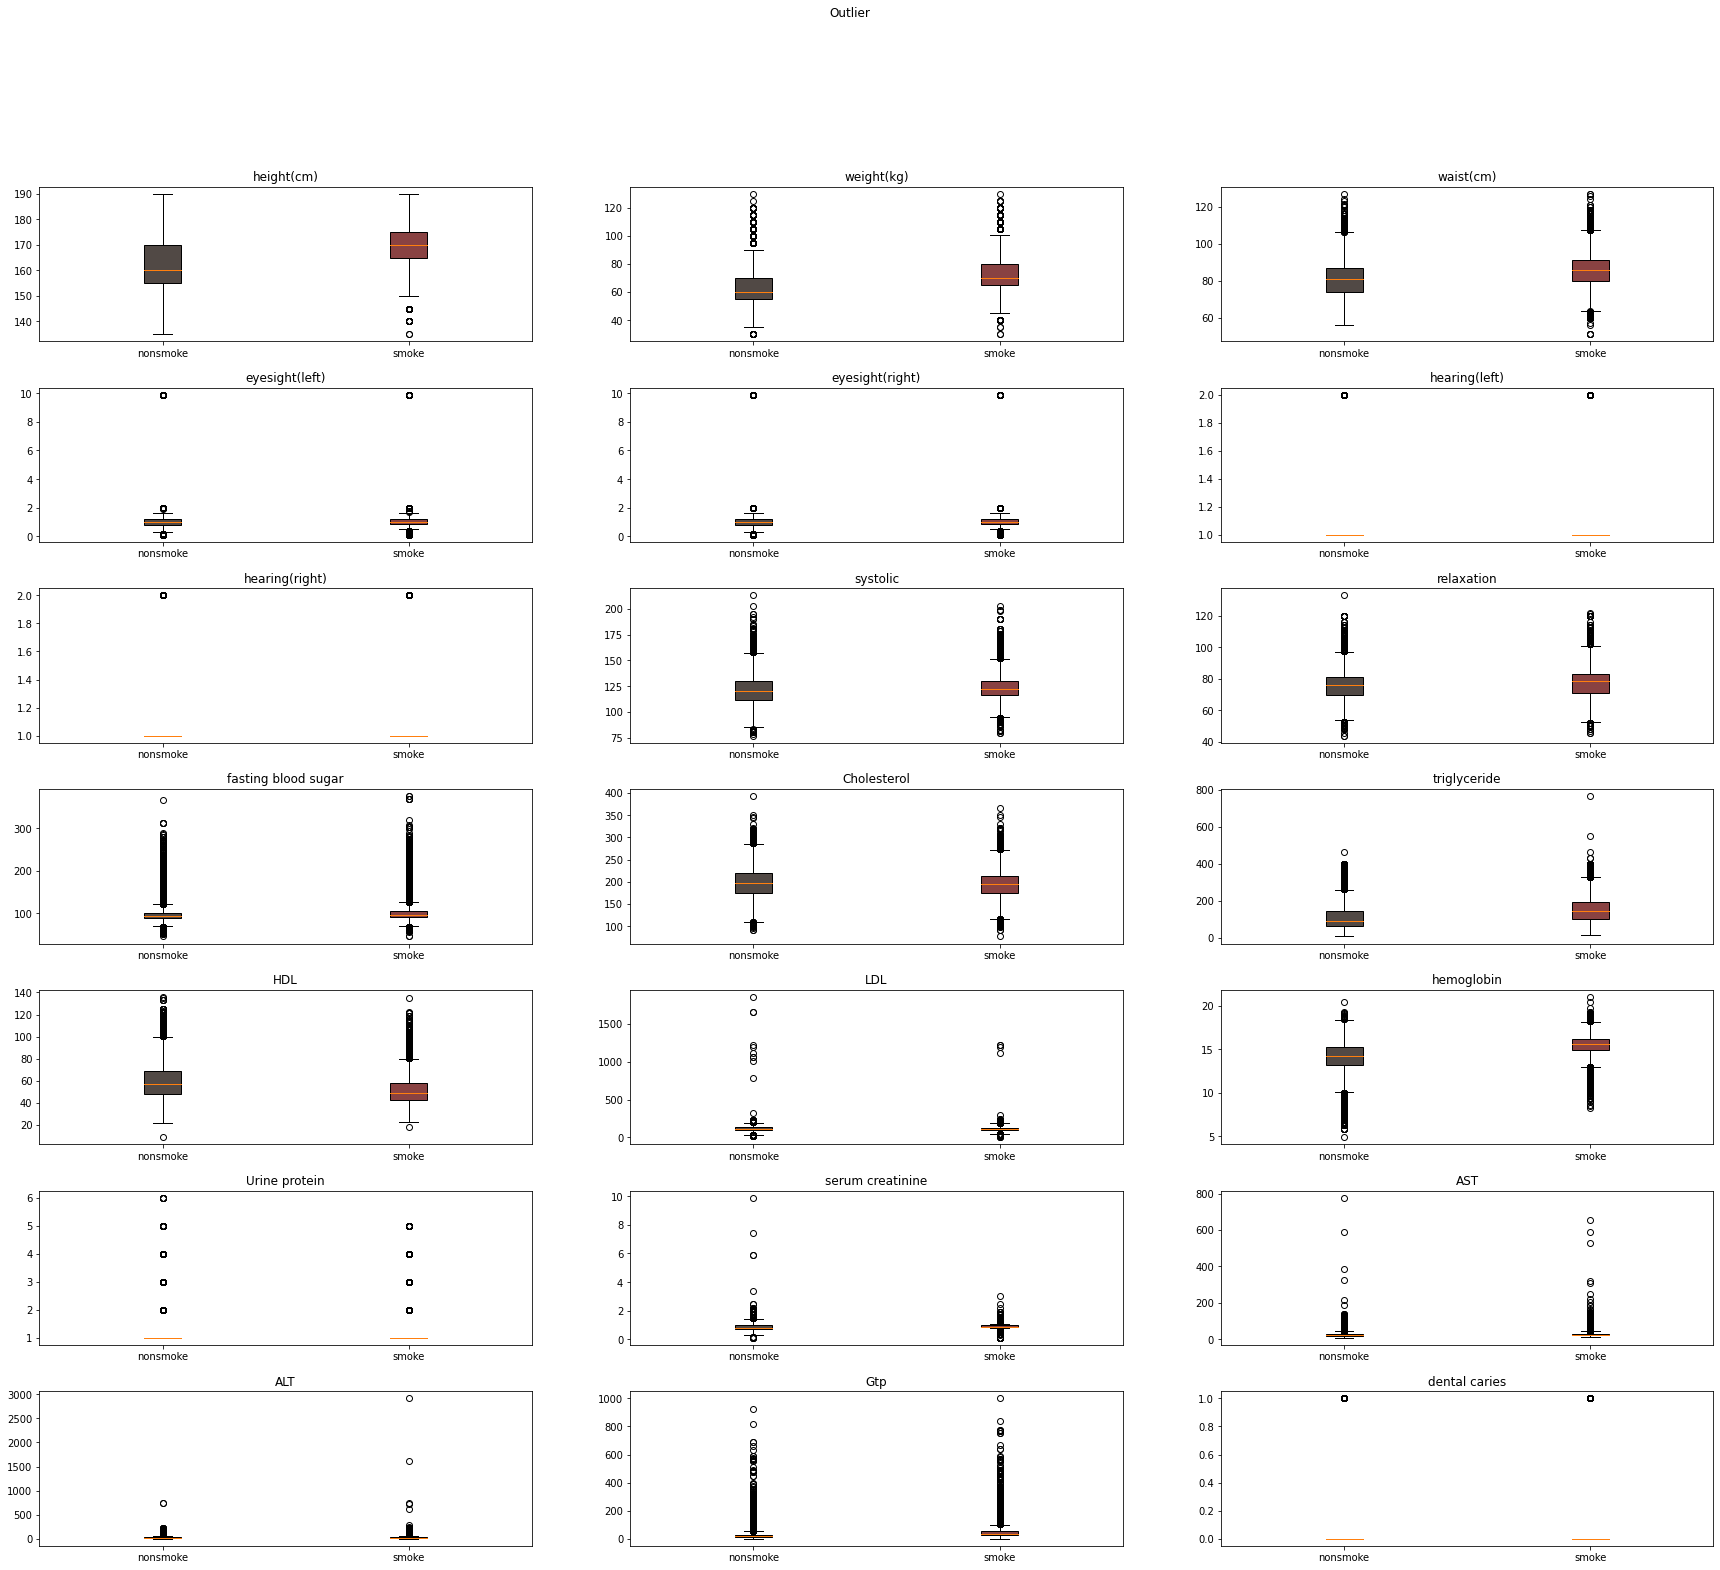

In [63]:
outiers_col = train[list(outliers.any()[outliers.any() == True].index)].select_dtypes(include='number').columns
fig, axs = plt.subplots(7, 3,figsize=(30, 25))
train_nonsmoke = train[train['smoking'] == 0]
train_smoke = train[train['smoking'] == 1]
cnt = 0
for i in range(7):
    for j in range(3):
        data = [train_nonsmoke[outiers_col[cnt]], train_smoke[outiers_col[cnt]]]
        xticklables = ['nonsmoke', 'smoke']
        axs[i,j].set_xticklabels(xticklables)
        plot = axs[i,j].boxplot(data,patch_artist=True)
        axs[i,j].set_title(outiers_col[cnt])
        colors = ['#514945', '#894242']
        for patch, color in zip(plot['boxes'], colors):
            patch.set_facecolor(color)
        cnt += 1
plt.suptitle('Outlier')
plt.tight_layout
plt.subplots_adjust(hspace = 0.3)
plt.show()

In [5]:
train.dtypes

id                       int64
age                      int64
height(cm)               int64
weight(kg)               int64
waist(cm)              float64
eyesight(left)         float64
eyesight(right)        float64
hearing(left)            int64
hearing(right)           int64
systolic                 int64
relaxation               int64
fasting blood sugar      int64
Cholesterol              int64
triglyceride             int64
HDL                      int64
LDL                      int64
hemoglobin             float64
Urine protein            int64
serum creatinine       float64
AST                      int64
ALT                      int64
Gtp                      int64
dental caries            int64
smoking                  int64
dtype: object

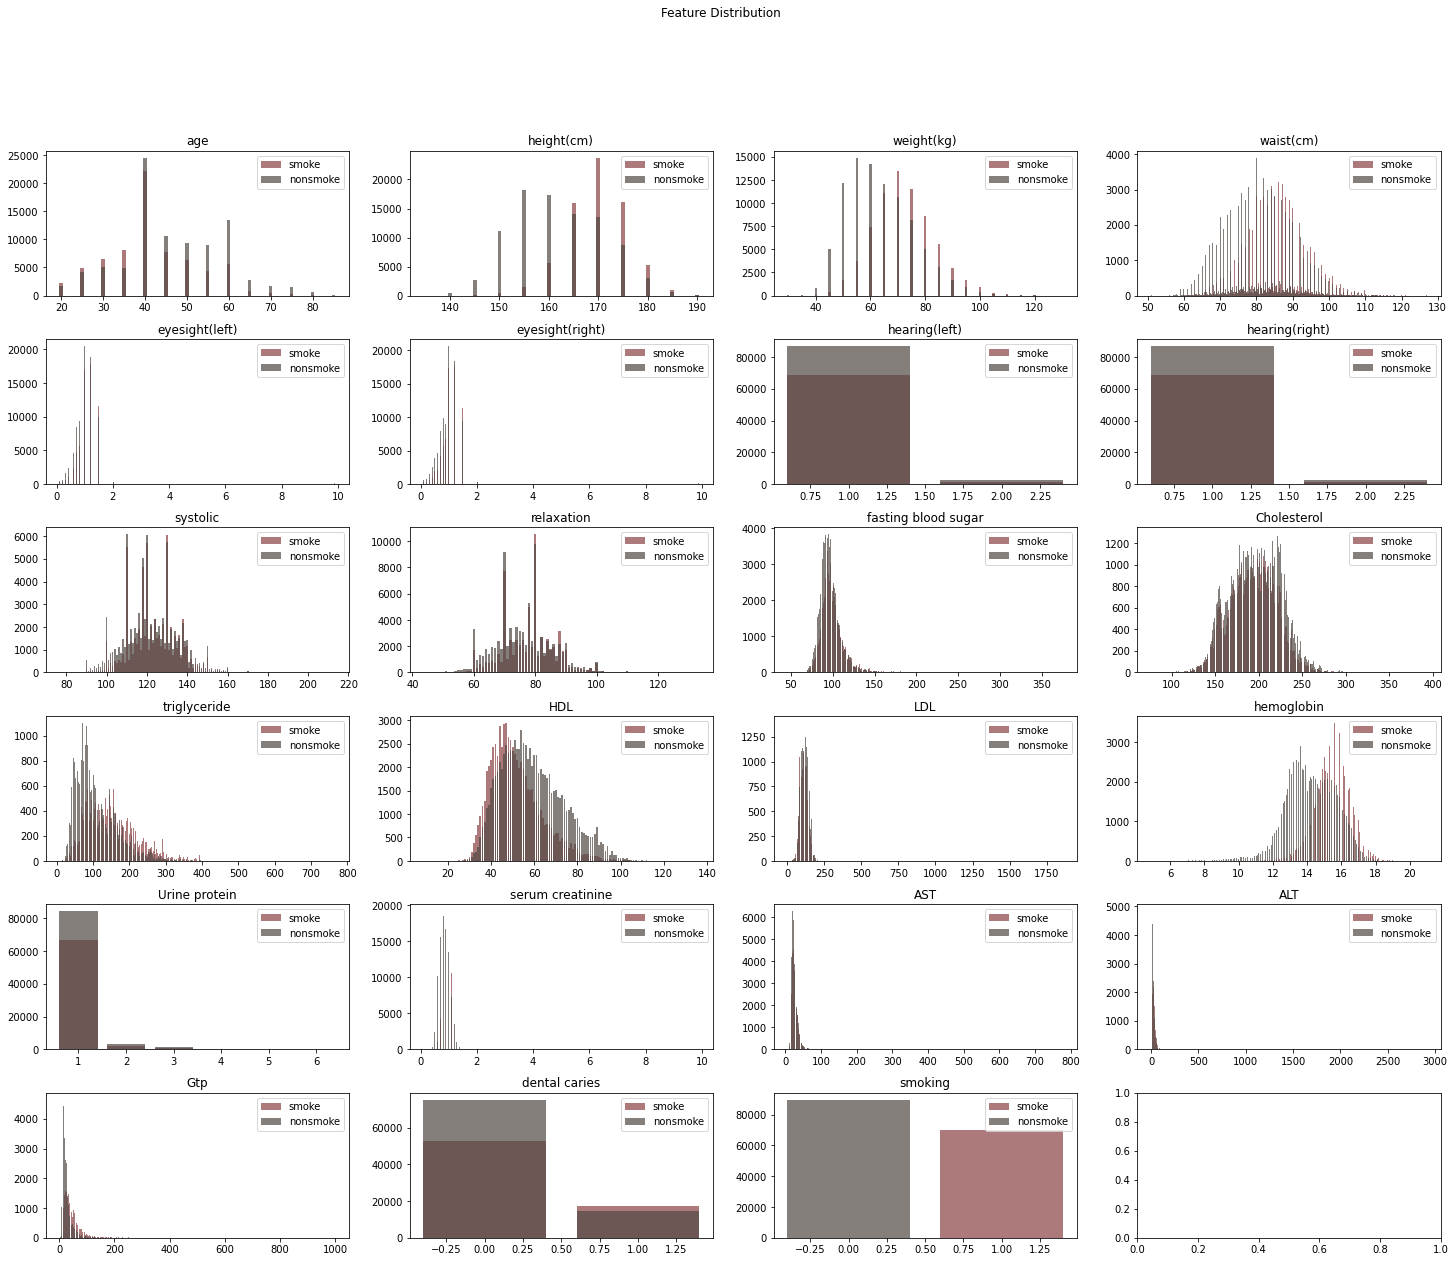

In [6]:
fig, axs = plt.subplots(6, 4,figsize=(25, 20))
cnt = 1
for i in range(6):
    for j in range(4):
        if cnt == 24:
            break
        column_smoke = train[train['smoking'] == 1].iloc[:, cnt]
        column_nonsmoke = train[train['smoking'] == 0].iloc[:,cnt]
        if column_smoke.dtype == float:
            axs[i,j].hist(column_smoke, 300, color = '#894242', alpha=0.7, label = 'smoke')
            axs[i,j].hist(column_nonsmoke, 300, color = '#514945', alpha=0.7, label = 'nonsmoke')
        else:
            axs[i,j].bar(column_smoke.value_counts().index, column_smoke.value_counts(), color = '#894242', alpha=0.7, label = 'smoke')
            axs[i,j].bar(column_nonsmoke.value_counts().index, column_nonsmoke.value_counts(), color = '#514945', alpha=0.7, label = 'nonsmoke')
        axs[i,j].legend()
        axs[i,j].set_title(train.columns[cnt])
        cnt += 1
plt.suptitle('Feature Distribution')
plt.tight_layout
plt.subplots_adjust(hspace = 0.3)
plt.show()

People who do not smoke tend to have less height, weight, waist, hearings, triglyceride, hemoglobin, serum creatinine, Gtp, and dental caries than smoke.  
People who smoke tend to have less HDL than people who do not.

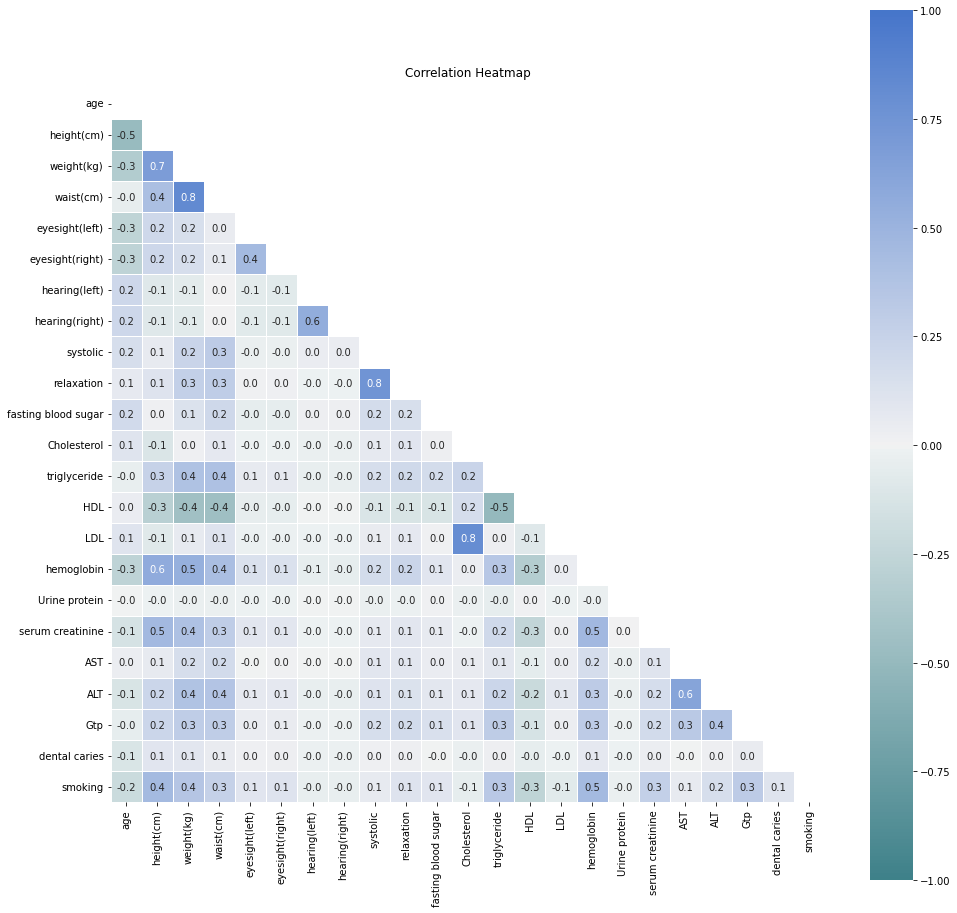

In [7]:
plt.figure(figsize=(16, 16))
corr_matrix = train.drop(columns = ['id']).corr()
diag_corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).T.astype(bool))
heatmap = sns.heatmap(diag_corr_matrix, vmin=-1, vmax=1, annot=True, linewidths=.5, fmt='.1f', square=True, cmap = sns.diverging_palette(205, 255, sep=1, n=256, as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [10]:
diag_corr_matrix.iloc[-1].sort_values(ascending=False)

hemoglobin             0.450679
height(cm)             0.447111
weight(kg)             0.351748
triglyceride           0.331975
Gtp                    0.305561
serum creatinine       0.272979
waist(cm)              0.262715
ALT                    0.163016
eyesight(right)        0.109781
relaxation             0.109501
dental caries          0.106636
eyesight(left)         0.100420
fasting blood sugar    0.096534
AST                    0.059394
systolic               0.058642
Urine protein         -0.028548
hearing(right)        -0.036858
hearing(left)         -0.038219
Cholesterol           -0.051896
LDL                   -0.072285
age                   -0.206033
HDL                   -0.271186
smoking                     NaN
Name: smoking, dtype: float64

# Model

In [152]:
X, y = train.drop(columns=['id', 'smoking']), train['smoking']
kfold = KFold(n_splits=5)
kfold_idx = kfold.split(X)

## Baseline: Logistic Regression

In [129]:
# cross validation logistic regression
model = LogisticRegression(random_state=0, solver = 'sag', verbose=1)
scores = cross_val_score(model, X, y, cv=kfold, n_jobs=-1, scoring = 'roc_auc')
max_score_idx = np.argmax(scores)
best_model = [model.fit(X.iloc[training], y.iloc[training]) for training, testing in kfold_idx][max_score_idx]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 6 seconds


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 6 seconds


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s finished


In [127]:
# write output into csv file
output = best_model.predict_proba(test.drop(columns = ['id']))
submission = test[['id']]
submission['smoking'] = output[:,1]
submission.to_csv('out_logregression.csv', index=False)  

<ipython-input-127-03a33a403669>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['smoking'] = output[:,1]


# XGBoost

In [153]:
# cross validation xgboost
model = XGBClassifier()
scores = cross_val_score(model, X, y, cv=kfold, n_jobs=-1, scoring = 'roc_auc')
max_score_idx = np.argmax(scores)
print(max_score_idx)
best_model = [model.fit(X.iloc[training], y.iloc[training]) for training, testing in kfold_idx][max_score_idx]



# data_dmatrix = xgb.DMatrix(data=X,label=y)
# params = {'objective':'binary:logistic','eval_metric':'logloss','eta':0.01,'subsample':0.1}
# xgb_cv = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, metrics = 'logloss',seed=0) 
# xgb_cv

3


In [154]:
# write output into csv file
output = best_model.predict_proba(test.drop(columns = ['id']))
submission = test[['id']]
submission['smoking'] = output[:,1]
submission.to_csv('out_XGB.csv', index=False)  

<ipython-input-154-fd024ff89a28>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['smoking'] = output[:,1]
